# Data Casal Montserratina

In [68]:
#Data Manipulation
import pandas as pd
import numpy as np

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

#Others
import os
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose

#Parameters Dict
parameters = {
    "paths": {
        "2022_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202201_202206.csv",
        "2022_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202207_202212.csv",
        "2023_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202301_202306.csv",
        "2023_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202307_202312.csv",
        "2024_01_05": "../data/data_casal_montserratina/Casal_Montserratina_202401_202405.csv",
    }
}

# Funciones

In [69]:
def grafico_zoom(df_x, df_y, title="", yaxis_title=""):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_x, 
        y=df_y, 
        mode='lines', 
        name='Line', 
        connectgaps=False 
    ))
    fig.update_layout(
        title=title,  
        yaxis_title=yaxis_title, 
        xaxis_tickangle=0, 
        showlegend=False
    )
    fig.show()

In [70]:
#Prints the NaN Values per Column of a dataset
def checkNaNValues(df):
    return print(f"NaN Count per Column", df.isna().any(axis=1).sum())

In [71]:
#Checks if there is any missing time series
def checkMissingData(df, date_column):
    min_date = df[date_column].min()
    max_date = df[date_column].max()

    date_range = pd.date_range(start=min_date, end=max_date, freq='h')
    missing_dates = date_range[~date_range.isin(df[date_column])]
    print(f"Number of Missing Values: {missing_dates.shape[0]}")
    return None if missing_dates.shape[0] == 0 else missing_dates, date_range

In [72]:
def getNumberOfOutliersPerColumn(df, columns_list):
    for col in columns_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        #Calcular los límites inferiores y superiores para identificar outliers
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr

        outliers = ((df[col] < lim_inf) | (df[col] > lim_sup))
        print(f"For {col} Column, the Number of Outliers is {outliers.sum()}. Sus limites son {lim_inf} y {lim_sup}.\n")

In [73]:
def dataframe_slicer (df, fecha_inicial, fecha_final):
    """
    Recorta el DataFrame en base a una fecha inicial y otra final.

    Parameters:
    df (DataFrame): El DataFrame original que contiene los datos.
    fecha_inicial (str): La fecha inicial en formato 'YYYY-MM-DD HH:MM:SS'.
    fecha_final (str): La fecha final en formato 'YYYY-MM-DD HH:MM:SS'.

    Returns:
    DataFrame: Un nuevo DataFrame recortado.
    """
    # Convertir las columnas de fecha a datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Filtrar el DataFrame en base a las fechas
    df_recortado = df[(df['Date'] >= fecha_inicial) & (df['Date'] <= fecha_final)]
    
    return df_recortado

# Load Data

In [74]:
ruta_data = "../data/data_casal_montserratina/"

In [75]:
df1 = pd.read_csv(parameters["paths"]["2022_01_06"], delimiter=";")
df2 = pd.read_csv(parameters["paths"]["2022_07_12"], delimiter=";")
df3 = pd.read_csv(parameters["paths"]["2023_01_06"], delimiter=";")
df4 = pd.read_csv(parameters["paths"]["2023_07_12"], delimiter=";")
df5 = pd.read_csv(parameters["paths"]["2024_01_05"], delimiter=";")

In [76]:
# hago un concat de los 4 datasets, para Unir los DataFrames uno a continuación del otro
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df.head()

TimeStamp  Valor  Període tarifari Tipus lectura
0  01/01/2022 00:00      6                 6          Real
1  01/01/2022 01:00      6                 6          Real
2  01/01/2022 02:00      5                 6          Real
3  01/01/2022 03:00      7                 6          Real
4  01/01/2022 04:00      7                 6          Real

In [77]:
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], format="%d/%m/%Y %H:%M")
df = df.drop(columns=["Tipus lectura", "Període tarifari"])
df.rename(columns={'TimeStamp': 'Date', 
                   'Valor': 'Consumo'}, inplace=True)

# Missing values

In [78]:
checkNaNValues(df)
missing_dates, date_range = checkMissingData(df, 'Date')

NaN Count per Column 0
Number of Missing Values: 2906


In [79]:
# TODO porqué la linea sale continua si hay huecos en los datos???

grafico_zoom(df["Date"], df["Consumo"],
              "Consumo Eléctrico (con Huecos) Casal La Monserratina - Años 2022, 2023 y 2024", "Consumo [kWh]")

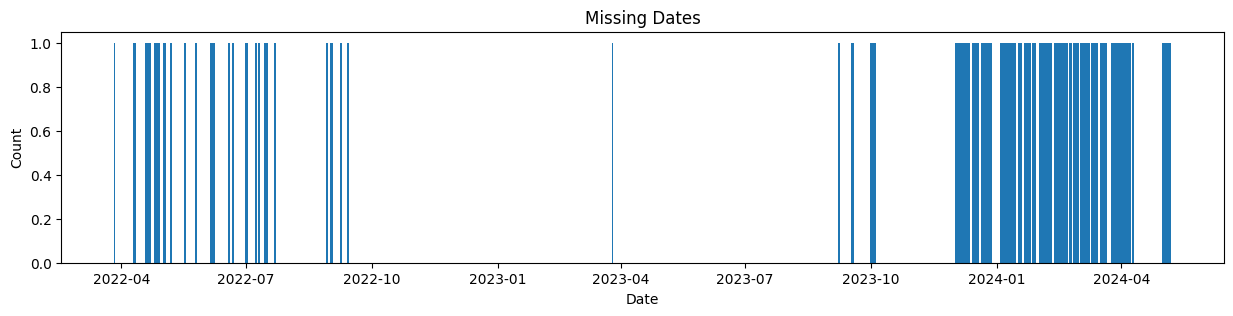

In [80]:
plt.figure(figsize=(15, 3))
plt.bar(missing_dates, [1] * len(missing_dates))
plt.title("Missing Dates")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

Un ejemplo de fechas faltantes; notar que entre las 01:00 y las 03:00 no hay datos. 

In [81]:
print(df[(df["Date"]>="2022-03-27 00:00:00") & (df["Date"]<"2022-03-27 05:00:00")])

                    Date  Consumo
2040 2022-03-27 00:00:00        2
2041 2022-03-27 01:00:00        3
2042 2022-03-27 03:00:00        2
2043 2022-03-27 04:00:00        2


### rellenar los huecos de Date

In [82]:
df = df.drop_duplicates(keep=False) # duplicados no hay, pero surgió un par de veces ese error al hacer el reindex. 

df.set_index("Date", inplace=True)

# Reindexa el DataFrame con el nuevo rango de fechas y rellena los valores faltantes con NaN
data_reindexed = df.reindex(date_range)

data_reindexed.reset_index(inplace=True)
data_reindexed.rename(columns={'index': 'Date'}, inplace=True) 

Ya no hay huecos en la columna Date, ahora aparecen rellenas!... con Nulls, tiny bam! 

In [83]:
print(data_reindexed[(data_reindexed["Date"]>="2022-03-27 00:00:00") & (data_reindexed["Date"]<"2022-03-27 05:00:00")])

                    Date  Consumo
2040 2022-03-27 00:00:00      2.0
2041 2022-03-27 01:00:00      3.0
2042 2022-03-27 02:00:00      NaN
2043 2022-03-27 03:00:00      2.0
2044 2022-03-27 04:00:00      2.0


### Interpolación NaN´s 

antes de hacer la interpolación, quiero entender como están distribuidos esos grupos de NaN´s a lo largo del DF. Lo que me interesa es poder aplicar interpolación en los huecos pequeños (que no suma muhco error) y dejar tal cual los huecos grandes.

In [84]:
def consecutive_nans(series):
    # Crear una serie booleana que es True donde la serie original es NaN
    is_nan = series.isna()

    # Identificar grupos de NaNs consecutivos
    nan_groups = ((is_nan.shift() != is_nan).cumsum()).where(is_nan, np.nan)
    print(nan_groups.isna().sum())
    # Contar el tamaño de cada grupo
    group_sizes = nan_groups.value_counts()#.sort_index()

    # Imprimir la lista de tamaños de grupos
    return group_sizes.tolist()


17684
2908
24     28
96      7
48      7
72      6
120     4
1       4
168     1
144     1
Name: count, dtype: int64


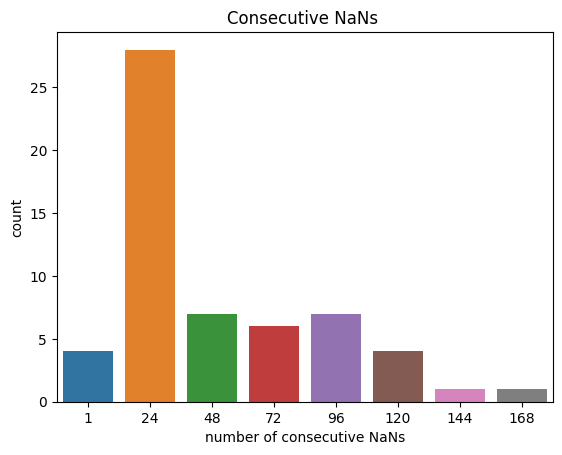

In [85]:
list_consecutive_nans = consecutive_nans(data_reindexed['Consumo'])
print(sum(list_consecutive_nans))

count = pd.Series(list_consecutive_nans).value_counts()
print(count.sort_values(ascending=False))
    
ax = sns.barplot(x=count.index, y=count.values)
ax.set_title('Consecutive NaNs ')
ax.set_xlabel('number of consecutive NaNs')
ax.set_ylabel('count')

plt.show()

Veo que en general, huecos (como filas de NaN´s consecutivos) se agurpan en bloques de 24. Dado los datos vienen en frecuencia horaria, 24 NaN´s seguidos corresponden a 1 día, y 168 a 7 días. 

Tenía intención de hacer una función que haga interpolación **SOLO** de los bloques de NaN´s cortos, como para no afectar demasiado la función objetivo.
Puede hacerse interpolación de los pocos huecos de 1 hora (solo afectaría a 4 huecos), y el siguiente treshold sería ya de interpolar 24 horas... interpolaré hasta los bloques de 24 horas.

In [86]:
def interpolate_with_threshold(df, column, threshold):
    # Create a mask of NaNs
    mask = df[column].isna()

    # Identify groups of consecutive NaNs
    mask_diff = mask.diff().fillna(False)
    groups = mask_diff.cumsum()[mask]

    # Count the size of each group
    group_counts = groups.map(groups.value_counts())

    # Create a mask for groups that are less than or equal to the threshold
    interpolate_mask = group_counts <= threshold

    # Interpolate only where the mask is True
    df[column] = df[column].mask(mask).interpolate().where(interpolate_mask, df[column])

    # Count and print the number of interpolated and not interpolated values
    interpolated_count = interpolate_mask.sum()
    not_interpolated_count = mask.sum() - interpolated_count

    print(f"Interpolated count: {interpolated_count}")
    print(f"Not interpolated count: {not_interpolated_count}")

In [87]:
interpolate_with_threshold(data_reindexed, 'Consumo',25)

Interpolated count: 676
Not interpolated count: 2232


C:\Users\afernandez\AppData\Local\Temp\ipykernel_14296\2588710448.py:6: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [88]:
grafico_zoom(data_reindexed["Date"], data_reindexed["Consumo"],
              "Consumo Eléctrico (con (algunos) huecos reindexados) Casal La Monserratina - Años 2022, 2023 y 2024", "Consumo [kWh]")

## Gaficas varias de la variable Consumo

### consumo resampleado a una semana

In [89]:
# Weekly Demand Plot
whole_df_1w = df.resample('1W').mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=whole_df_1w.index, y=whole_df_1w["Consumo"], mode='lines'))
fig.update_layout(
    title = "Consumo Eléctrico (Resample 1 semana) - Casal La Monserratina",
    xaxis_title = "Date",
    yaxis_title = "Demand (kWh)",
    width = 850,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### consumo mes a mes

In [90]:
import calendar
from plotly.subplots import make_subplots
def plot_monthly_Consumo(df):
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    groups = df.groupby([df.index.year, df.index.month])
    num_plots = len(groups)
    fig = make_subplots(rows=6, cols=2, subplot_titles=[calendar.month_name[i] for i in range(1, 13)], horizontal_spacing=0.1, vertical_spacing=0.05)
    #colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    colors = ['blue', 'orange', 'green']

    for month in range(1, 13):
        row = (month - 1) // 2 + 1
        col = (month - 1) % 2 + 1
        monthly_data = df[df.index.month == month]
        unique_years = monthly_data.index.year.unique()
        for i, year in enumerate(unique_years):
            year_data = monthly_data[monthly_data.index.year == year]
            year_data = year_data.copy()
            year_data.index = year_data.index.map(lambda x: x.replace(year=2022))  # Normalizar el año para superponer curvas
            fig.add_trace(
                go.Scatter(x=year_data.index, y=year_data["Consumo"], mode='lines', name=f"{year}",
                           legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=False),
                row=row, col=col
            )
        if month == 1:
            for i, year in enumerate(unique_years):
                fig.add_trace(
                    go.Scatter(x=[None], y=[None], mode='lines', name=f"{year}",
                            legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=True),
                    row=row, col=col
                )
                
        fig.update_xaxes(title_text="Date", row=row, col=col)
        fig.update_yaxes(title_text="Consumo (kWh)", row=row, col=col)
    fig.update_layout(
        title = {
            "text": "Monthly Energy Consumo",
            'x': 0.5,
            'xanchor': 'center'
        },
        xaxis_title="Date",
        yaxis_title="Consumo (kWh)",
        width=1200,
        height=2000,
        margin=dict(l=20, r=20, t=45, b=20)   
    )
    fig.show()

plot_monthly_Consumo(df)

## Slice Dataset
la idea es quedarse solo con la zona central, dejando fuera los picos del inicio, y los huecos del final. 

In [91]:
# Definir las fechas inicial y final
fecha_inicial = '2022-07-02 00:00:00' # 'YYYY-MM-DD HH:MM:SS'.
fecha_final = '2023-11-30 23:00:00'

# Obtener el DataFrame recortado
df_sliced = dataframe_slicer(data_reindexed, fecha_inicial, fecha_final)

In [92]:
grafico_zoom(df_sliced["Date"], df_sliced["Consumo"],
              "Consumo Eléctrico Casal La Monserratina - de Julio 2022 a Dic 2023 ", "Consumo [kWh]")

### Outliers del df_sliced

In [93]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1306. Sus limites son -2.5 y 9.5.



c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Text(0.5, 0, 'Consumo [kWh]')

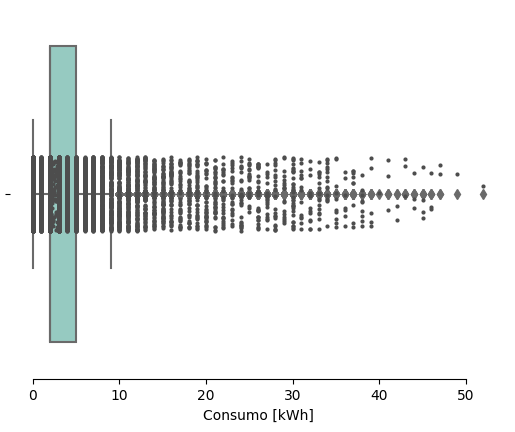

In [94]:
sns.boxplot(df_sliced, x="Consumo", width=0.8, palette="Set3")
# Add in points to show each observation
sns.stripplot(df_sliced, x="Consumo", size=3, color=".3")
sns.despine(trim=True, left=True)
plt.xlabel("Consumo [kWh]")

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0.5, 0, 'Consumo [kWh]')

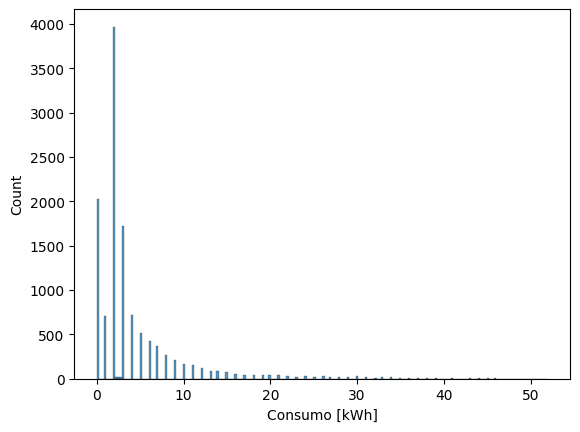

In [95]:
sns.histplot(df_sliced, x="Consumo")
plt.xlabel("Consumo [kWh]")

## Smoothing w/moving average

In [96]:
from statsmodels.robust.scale import mad

# Define the window size for the rolling mean
window_size = 3 # datos horarios, es decir, que el window_size esta en horas.


# Calculate the rolling mean
df_sliced['Consumo_smooth_mean'] = df_sliced['Consumo'].rolling(window=window_size).mean()
#df_sliced['Consumo_smooth_std'] = df_sliced['Consumo'].rolling(window=window_size).std()
#df_sliced['Consumo_smooth_MAD'] = df_sliced['Consumo'].rolling(window=window_size).apply(mad)

C:\Users\afernandez\AppData\Local\Temp\ipykernel_14296\2023304538.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
# Create traces for original and smoothed data
trace_original = go.Scatter(x=df_sliced["Date"], y=df_sliced['Consumo'], mode='lines', name='Original')
trace_smoothed_mean = go.Scatter(x=df_sliced["Date"], y=df_sliced['Consumo_smooth_mean'], mode='lines', name='Smoothed Mean')

# Create layout
layout = go.Layout(title='Original vs Smoothed Data', xaxis=dict(title='Date'), yaxis=dict(title='Consumption [kWh]'))

# Create figure
fig = go.Figure(data=[trace_original, trace_smoothed_mean], layout=layout)

# Show figure
fig.show()

el rooling average lo que hace es calcular una media variable de la ventana definida. en este caso son bloques horarios, ej: window_size=3 hace un promedio de las ultimas 3 horas (aun no se ha aplicado upsampling a 15 min). Si bien no es la mejor idea utilizar una variable modificada como funcion objetivo, pareciera que la curva resultante tiene mucho menos ruido y copia casi perfectamente la curva original.

### Outliers del smoothed DF

In [98]:
df_sliced.describe()

Date       Consumo  Consumo_smooth_mean
count                12408  12288.000000         12282.000000
mean   2023-03-17 11:30:00      4.222168             4.223036
min    2022-07-02 00:00:00      0.000000             0.000000
25%    2022-11-08 05:45:00      2.000000             2.000000
50%    2023-03-17 11:30:00      2.000000             2.333333
75%    2023-07-24 17:15:00      5.000000             4.666667
max    2023-11-30 23:00:00     52.000000            47.666667
std                    NaN      5.769920             5.224750

In [99]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1306. Sus limites son -2.5 y 9.5.

For Consumo_smooth_mean Column, the Number of Outliers is 1370. Sus limites son -2.0 y 8.666666666666668.



Es curioso que aún siendo una técnica que suaviza los datos, los outliers aumentan.

Text(0.5, 0, 'Consumo_smooth_mean [kWh]')

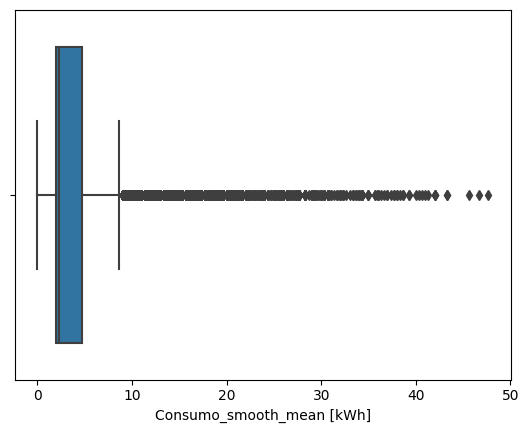

In [100]:
sns.boxplot(df_sliced, x="Consumo_smooth_mean")
plt.xlabel("Consumo_smooth_mean [kWh]")

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0.5, 0, 'Consumo_smooth_mean [kWh]')

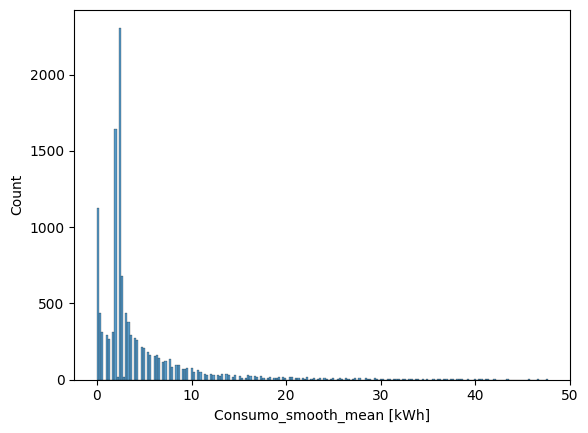

In [101]:
sns.histplot(df_sliced, x="Consumo_smooth_mean")
plt.xlabel("Consumo_smooth_mean [kWh]")

No sé si se utilizará la versión de Consumo_smooth_mean, la dejo por si en el modelo de ML mejora en algo. 

# upsampling a 15 min

In [102]:
df_upsampled = df_sliced.copy()

In [103]:
df_upsampled.set_index("Date", inplace=True)

In [104]:
df_upsampled = df_upsampled.resample('15min').interpolate(method='time')
df_upsampled

Consumo  Consumo_smooth_mean
Date                                             
2022-07-02 00:00:00     3.00                  NaN
2022-07-02 00:15:00     2.75                  NaN
2022-07-02 00:30:00     2.50                  NaN
2022-07-02 00:45:00     2.25                  NaN
2022-07-02 01:00:00     2.00                  NaN
...                      ...                  ...
2023-11-30 22:00:00     2.00             3.666667
2023-11-30 22:15:00     2.00             3.416667
2023-11-30 22:30:00     2.00             3.166667
2023-11-30 22:45:00     2.00             2.916667
2023-11-30 23:00:00     2.00             2.666667

[49629 rows x 2 columns]

# Merge Consumo con PPV

In [108]:
# Load & prepatation of the DataFrame with the PV & weather data

nombre_archivo = "LaMonserratina_weather_&_PV.csv"
df_PV = pd.read_csv(os.path.join(ruta_data, nombre_archivo))

df_PV.rename(columns={"date": "Date"}, inplace=True)
df_PV.drop(columns=["Unnamed: 0"], inplace=True)

df_PV.sample(5)

Date  temperature_2m_C  relative_humidity_2m_%  \
62812  2022-10-17 07:00:00         20.871500               94.013092   
85080  2023-06-06 06:00:00         19.671501               84.960579   
80161  2023-04-16 00:15:00         13.196500               86.931305   
79299  2023-04-07 00:45:00          9.184000               96.043678   
19998  2021-07-28 07:30:00         24.371502               72.231918   

       dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
62812       19.871500               22.729542       1023.000000   
85080       17.071500               21.127052       1015.299988   
80161       11.059000               12.858973       1018.375000   
79299        8.584000                7.632335       1019.625000   
19998       19.046501               25.156433       1015.000000   

       surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
62812           1017.195435          100.0               98.00   
85080           1009.515442           38.4              100.00   
80161           1012.442139           19.5               58.25   
79299           1013.600830            0.0                0.00   
19998           1009.308350           24.0                0.00   

       et0_fao_evapotranspiration_mm  ...  is_day  sunshine_duration_sec  \
62812                       0.021579  ...     1.0                 0.0000   
85080                       0.062105  ...     1.0              3184.2612   
80161                       0.000000  ...     0.0                 0.0000   
79299                       0.000000  ...     0.0                 0.0000   
19998                       0.216106  ...     1.0              3600.0000   

       shortwave_radiation_W/m2  direct_radiation_W/m2  \
62812                      27.0                    4.0   
85080                     104.0                   32.0   
80161                       0.0                    0.0   
79299                       0.0                    0.0   
19998                     302.5                  212.0   

       diffuse_radiation_W/m2  direct_normal_irradiance_W/m2  \
62812                    23.0                      34.919975   
85080                    72.0                     166.142044   
80161                     0.0                       0.000000   
79299                     0.0                       0.000000   
19998                    90.5                     509.552246   

       global_tilted_irradiance_W/m2  terrestrial_radiation_W/m2  \
62812                           27.0                   98.521202   
85080                          104.0                  255.903229   
80161                            0.0                    0.000000   
79299                            0.0                    0.000000   
19998                          302.5                  531.853394   

       Temp_interna_Modulo_C    PV_kWh  
62812              27.453636  0.210807  
85080              29.891115  0.986044  
80161              23.193884  0.000000  
79299              21.381405  0.000000  
19998              39.811615  2.787777  

[5 rows x 24 columns]

In [106]:
checkNaNValues(df_PV)

NaN Count per Column 0


In [109]:
# Preparación del df Consumo, para el merge

df_upsampled.rename(columns={"Consumo": "Consumo_kW"}, inplace=True)
df_upsampled.rename(columns={"Consumo_smooth_mean": "Consumo_smooth_mean_kW"}, inplace=True)

df_upsampled.reset_index(inplace=True)
df_upsampled['Date'] = pd.to_datetime(df_upsampled['Date'])
df_PV['Date'] = pd.to_datetime(df_PV['Date'])

In [110]:
df4 = df_upsampled.merge(df_PV, how="inner", on="Date")
df4.sample(2)

index                Date  Consumo_kW  Consumo_smooth_mean_kW  \
28173  28173 2023-04-21 11:15:00        0.75                1.166667   
12467  12467 2022-11-08 20:45:00        4.00                4.833333   

       temperature_2m_C  relative_humidity_2m_%  dew_point_2m_C  \
28173           18.1965               72.934784         13.2590   
12467           15.1090               94.602242         14.2465   

       apparent_temperature_C  pressure_msl_hPa  surface_pressure_hPa  ...  \
28173               18.509674       1010.000000           1004.216797  ...   
12467               15.444307       1015.650024           1009.772217  ...   

       is_day  sunshine_duration_sec  shortwave_radiation_W/m2  \
28173     1.0                 3600.0                    819.25   
12467     0.0                    0.0                      0.00   

       direct_radiation_W/m2  diffuse_radiation_W/m2  \
28173                  673.0                  146.25   
12467                    0.0                    0.00   

       direct_normal_irradiance_W/m2  global_tilted_irradiance_W/m2  \
28173                     806.088501                         819.25   
12467                       0.000000                           0.00   

       terrestrial_radiation_W/m2  Temp_interna_Modulo_C    PV_kWh  
28173                 1131.110718              43.755470  4.260882  
12467                    0.000000              24.057775  0.000000  

[2 rows x 27 columns]

## add some extra exogenous variables columns

In [111]:
df5 = df4.copy()
df5.sample(1)

index                Date  Consumo_kW  Consumo_smooth_mean_kW  \
39912  39912 2023-08-21 18:00:00         1.0                0.333333   

       temperature_2m_C  relative_humidity_2m_%  dew_point_2m_C  \
39912           28.1465                64.90905         22.3215   

       apparent_temperature_C  pressure_msl_hPa  surface_pressure_hPa  ...  \
39912               31.500716       1018.099976           1012.489685  ...   

       is_day  sunshine_duration_sec  shortwave_radiation_W/m2  \
39912     1.0                 3600.0                     137.0   

       direct_radiation_W/m2  diffuse_radiation_W/m2  \
39912                   77.0                    60.0   

       direct_normal_irradiance_W/m2  global_tilted_irradiance_W/m2  \
39912                     355.484039                          137.0   

       terrestrial_radiation_W/m2  Temp_interna_Modulo_C    PV_kWh  
39912                  289.512146              38.684807  1.963619  

[1 rows x 27 columns]

In [115]:
df5["Year"] = df5["Date"].dt.year
df5["Month"] = df5["Date"].dt.month
df5["Hour"] = df5["Date"].dt.hour
df5["DayOfWeek"] = df5["Date"].dt.day_of_week
df5["DayOfYear"] = df5["Date"].dt.day_of_year
df5["Day"] = df5["Date"].dt.day
#df5["Minute"] = df5["Date"].dt.minute

In [114]:
#Sine and Cosine Transformations
def cyclical_encoding(df, cycle_length_list, columns):
    for col, cycle_length in zip(columns, cycle_length_list):
        if df[col].min == 0:
            df[f"{col}_sin"] = np.sin((df[col] / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos((df[col] / cycle_length) * np.pi * 2).round(4)
        else:
            df[f"{col}_sin"] = np.sin(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
    return df

In [116]:

#Add isWeekend Column based in DayOfTheWeek Value
df5["isWeekend"] = df5["DayOfWeek"].isin([5, 6])

cycle_lengths = [24, 7, 12, 365]
cols = ["Hour", "DayOfWeek", "Month", "DayOfYear"]

df5 = cyclical_encoding(df5, cycle_lengths, cols)

df5.sample(5)

index                Date  Consumo_kW  Consumo_smooth_mean_kW  \
32615  32615 2023-06-06 17:45:00        8.00                3.166667   
37407  37407 2023-07-26 15:45:00        6.25                4.416667   
29029  29029 2023-04-30 09:15:00        1.75                1.416667   
7784    7784 2022-09-21 02:00:00        3.00                2.333333   
39068  39068 2023-08-12 23:00:00        2.00                2.333333   

       temperature_2m_C  relative_humidity_2m_%  dew_point_2m_C  \
32615         21.871500               77.690872       17.796501   
37407         25.784000               61.137630       17.721500   
29029         19.871502               81.488899       16.609001   
7784          19.071500               93.638313       18.021502   
39068         24.571500               89.999847       22.446500   

       apparent_temperature_C  pressure_msl_hPa  surface_pressure_hPa  ...  \
32615               23.188828       1014.775024           1009.036560  ...   
37407               26.241589       1016.724976           1011.050476  ...   
29029               21.649414       1015.150024           1009.370300  ...   
7784                21.244368       1017.900024           1012.088928  ...   
39068               29.585339       1019.099976           1013.389160  ...   

       Day  isWeekend  Hour_sin  Hour_cos  DayOfWeek_sin  DayOfWeek_cos  \
32615    6      False   -0.8660   -0.5000         0.0000         1.0000   
37407   26      False   -0.5000   -0.8660         0.7818         0.6235   
29029   30       True    0.8660   -0.5000        -0.9749        -0.2225   
7784    21      False    0.2588    0.9659         0.7818         0.6235   
39068   12       True   -0.5000    0.8660        -0.4339        -0.9010   

       Month_sin  Month_cos  DayOfYear_sin  DayOfYear_cos  
32615      0.500     -0.866         0.4405        -0.8977  
37407      0.000     -1.000        -0.3936        -0.9193  
29029      1.000      0.000         0.8881        -0.4597  
7784      -0.866     -0.500        -0.9829        -0.1840  
39068     -0.500     -0.866        -0.6421        -0.7667  

[5 rows x 42 columns]

In [117]:
def generateHolidayVar(df):
    df["Reduced_Date"] = df["Date"].dt.date
    list_holidays = holidays.Spain(prov="CT", years=list(df["Year"].unique()))
    list_holidays_dates = np.array(list(list_holidays.keys()), dtype='datetime64')
    df["isHoliday"] = df["Reduced_Date"].isin(list_holidays_dates)
    df = df.drop('Reduced_Date', axis=1)
    return df

df5 = generateHolidayVar(df5)
display(df5[["Date", "isHoliday"]].sample(5))

Date  isHoliday
18879 2023-01-14 15:45:00      False
20434 2023-01-30 20:30:00      False
23163 2023-02-28 06:45:00      False
16108 2022-12-16 19:00:00      False
39340 2023-08-15 19:00:00       True

# Plots

## Consumo por mes

Text(0.5, 0.98, '')

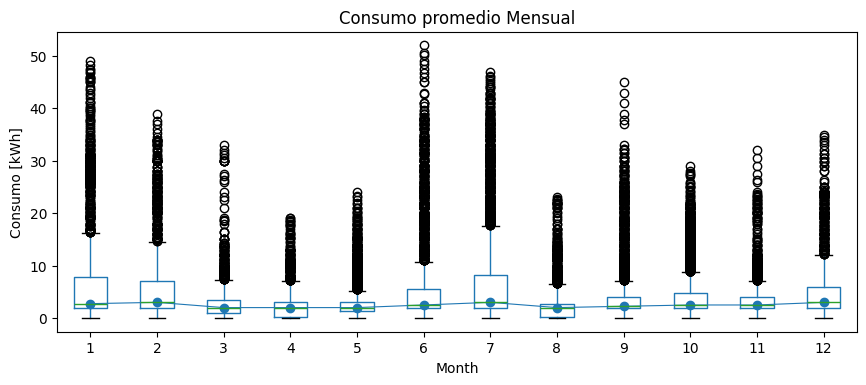

In [118]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Month', ax=ax)
df5.groupby('Month')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo [kWh]')
ax.set_title("Consumo promedio Mensual")
fig.suptitle('')

## Consumo total por día

Text(0.5, 0.98, '')

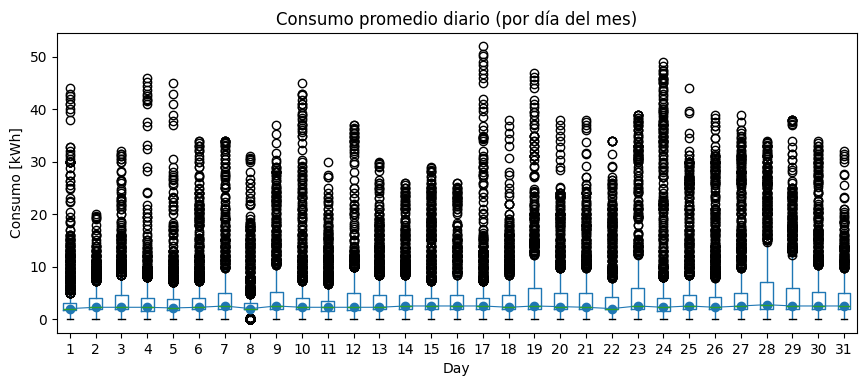

In [119]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Day', ax=ax)
df5.groupby('Day')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo [kWh]')
ax.set_title("Consumo promedio diario (por día del mes)")
fig.suptitle('')

Text(0.5, 0.98, '')

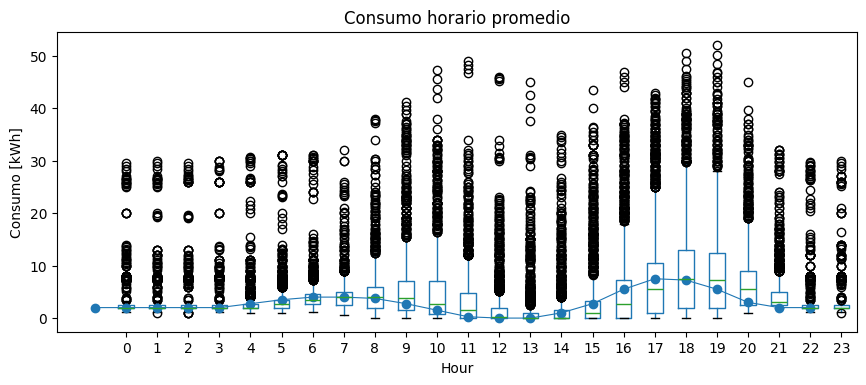

In [120]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Hour', ax=ax)
df5.groupby('Hour')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo [kWh]')
ax.set_title("Consumo horario promedio")
fig.suptitle('')

## Demand per Day and Season

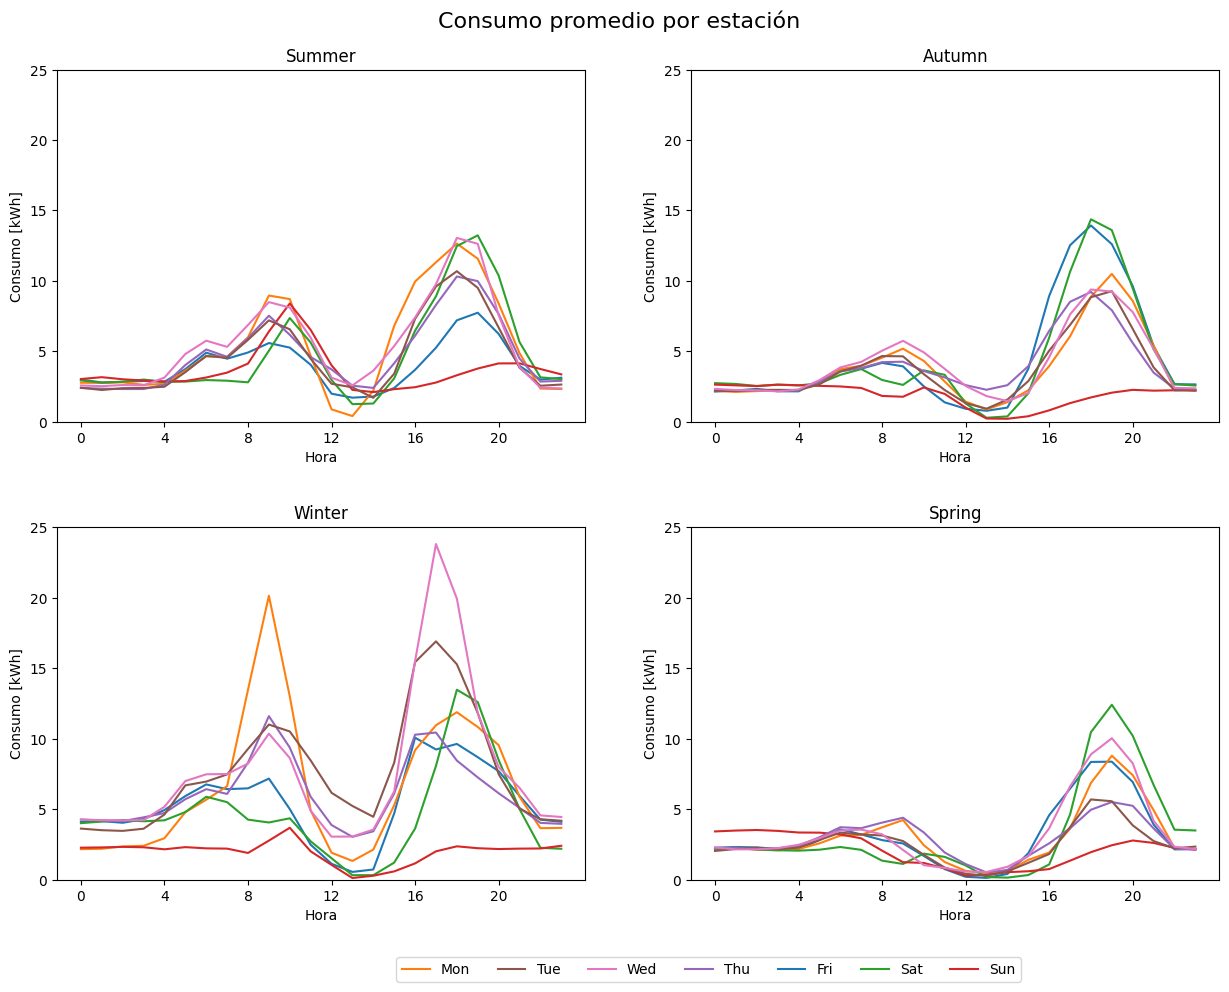

In [121]:
days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df5["Day"] = df5["DayOfWeek"].map(days_mapping)
df5["Season"] = df5["Month"].apply(
    lambda x: (
        1 if x in [3, 4, 5] #Spring
        else 2 if x in [6, 7, 8] #Summer
        else 3 if x in [9, 10, 11] #Autumn
        else 0 #Winter
    )
)
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.92)
fig.suptitle("Consumo promedio por estación", fontsize=16)

fig.set_figheight(10)
fig.set_figwidth(15)

ymin, ymax = 0, 25

#Season Summer
df5.loc[df5["Season"] == 2] \
    .groupby([df5.loc[df5["Season"] == 2]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[0, 0], ylim=(ymin, ymax), title="Summer", legend=False
    )
df5.loc[df5["Season"] == 3] \
    .groupby([df5.loc[df5["Season"] == 3]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[0, 1], ylim=(ymin, ymax), title="Autumn", legend=False
    )
df5.loc[df5["Season"] == 0] \
    .groupby([df5.loc[df5["Season"] == 0]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[1, 0], ylim=(ymin, ymax), title="Winter", legend=False
    )
df5.loc[df5["Season"] == 1] \
    .groupby([df5.loc[df5["Season"] == 1]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[1, 1], ylim=(ymin, ymax), title="Spring", legend=False
    )

for ax in axes.flat:
    ax.set(xlabel='Hora', ylabel='Consumo [kWh]')

for n in range(0, 2):
    axes[n, 0].set_xticks([0, 4, 8, 12, 16, 20])
    axes[n, 1].set_xticks([0, 4, 8, 12, 16, 20])
df5 = df5.drop("Day", axis=1)
# LEGEND
handles, labels = plt.gca().get_legend_handles_labels() # reorder Legend Labels
order = [1,5,6,4,0,2,3]      # specify order in Legend
axes[1,1].legend([handles[i] for i in order], [labels[i] for i in order], loc=1, ncol=7, 
                 bbox_to_anchor=(0.638,-0.2), frameon=True) # print and order LEGEND

## Temperature Distribution by Hour

Text(0.5, 0.98, '')

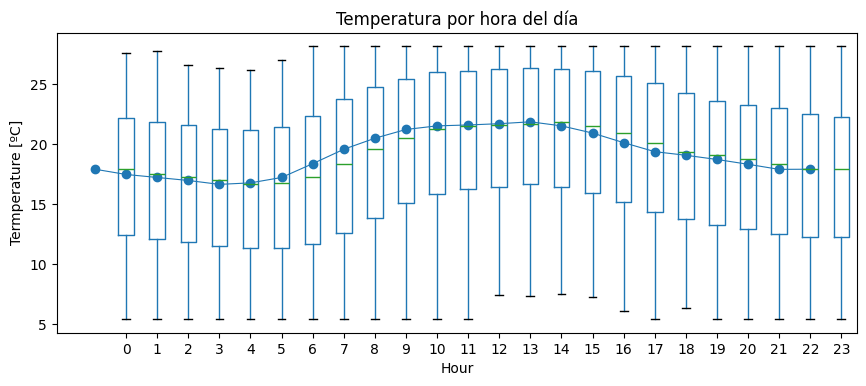

In [123]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='temperature_2m_C', by='Hour', ax=ax)
df5.groupby('Hour')['temperature_2m_C'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Termperature [ºC]')
ax.set_title("Temperatura por hora del día")
fig.suptitle('')

## Relacion entre Demanda Energética y Temperatura. 

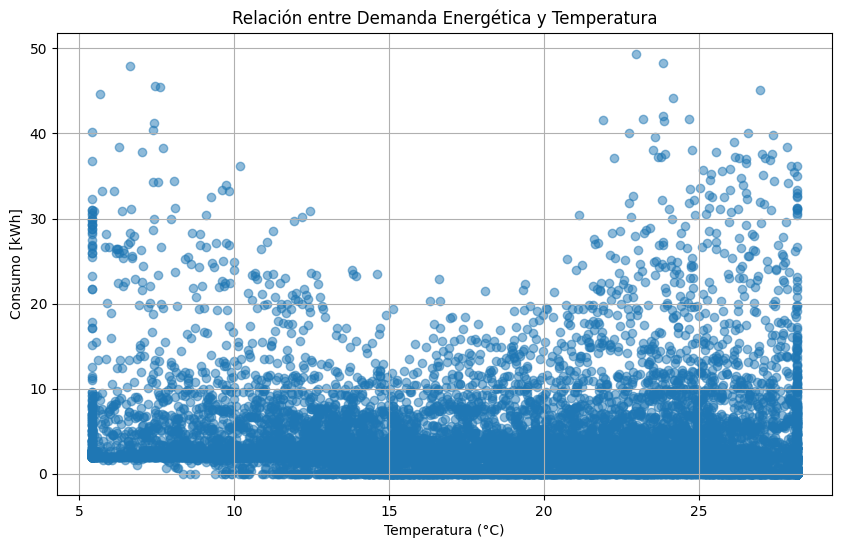

In [124]:
def plot_temp_vs_demand(df):
    df = df.copy()
    df.set_index("Date", inplace=True)
    df_1h = df.resample('1h').mean()
    plt.figure(figsize=(10, 6))
    plt.scatter(df_1h['temperature_2m_C'], df_1h['Consumo_kW'], alpha=0.5)
    plt.title('Relación entre Demanda Energética y Temperatura')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Consumo [kWh]')
    plt.grid(True)
    plt.show()
plot_temp_vs_demand(df5)

Si hubiese buena correlacion entre demanda y temperatura, los puntos deberían formar una especie de "U", ya que cuanto mayor o menor sea la temperatura, mayor será el consumo energético para mejorar el confort. 

Por otro lado, los bordes rectos se deben a la windsorización de la temperatura en el preprocessing. 

## Irradiacion Solar (Mensual)

Text(0.5, 0.98, '')

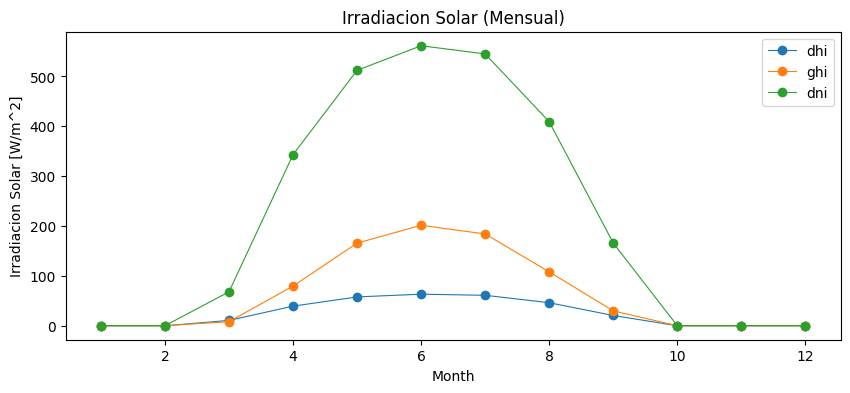

In [53]:
fig, ax = plt.subplots(figsize=(10, 4))

# df5.boxplot(column='dhi_W/m2', by='Month', ax=ax)
df5.groupby('Month')['dhi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='ghi_W/m2', by='Month', ax=ax)
df5.groupby('Month')['ghi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='dni_W/m2', by='Month', ax=ax)
df5.groupby('Month')['dni_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

ax.legend(['dhi', 'ghi', 'dni'])

# dhi                      Irradiancia solar difusa en el plano horizontal    W/m2 [Clear Sky] 
# ghi                      Irradiancia solar global en el plano horizontal    W/m2 [Clear Sky] 
# dni                      Irradiancia solar directa normal                   W/m2 [Clear Sky] 

ax.set_ylabel('Irradiacion Solar [W/m^2]')
ax.set_title("Irradiacion Solar (Mensual)")
fig.suptitle('')

## Irradiacion Solar (Horaria)

Text(0.5, 0.98, '')

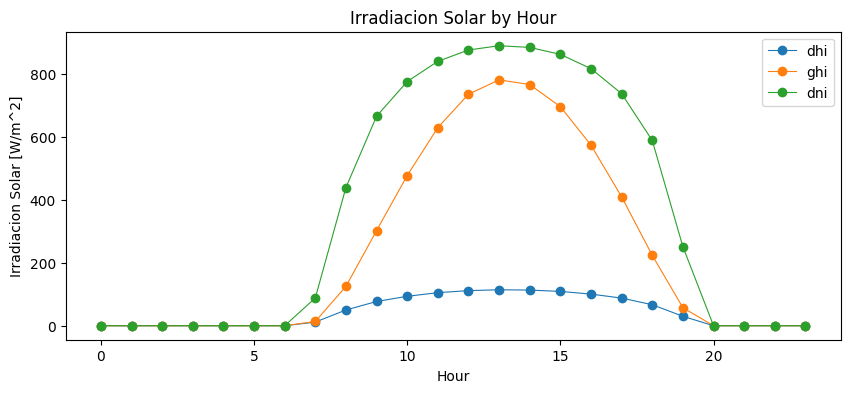

In [54]:
fig, ax = plt.subplots(figsize=(10, 4))

# df5.boxplot(column='dhi_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['dhi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='ghi_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['ghi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='dni_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['dni_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

ax.legend(['dhi', 'ghi', 'dni'])

# dhi                      Irradiancia solar difusa en el plano horizontal    W/m2 [Clear Sky] 
# ghi                      Irradiancia solar global en el plano horizontal    W/m2 [Clear Sky] 
# dni                      Irradiancia solar directa normal                   W/m2 [Clear Sky] 

ax.set_ylabel('Irradiacion Solar [W/m^2]')
ax.set_title("Irradiacion Solar by Hour")
fig.suptitle('')

## AutoCorrelation Plots

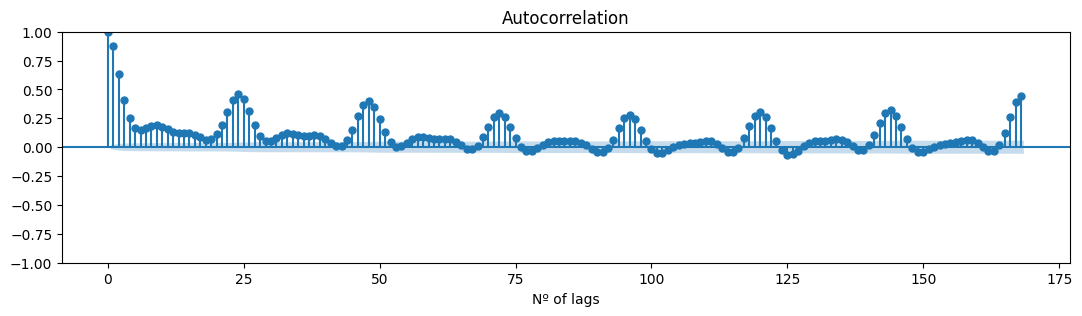

In [126]:
from statsmodels.graphics.tsaplots import plot_acf
#Gráfico de autocorrelación 1
df5.set_index("Date", inplace=True)
demand_df_1h = df5.resample('1h').mean()
fig, ax = plt.subplots(figsize=(13, 3))
plt.xlabel("Nº of lags")
plot_acf(demand_df_1h["Consumo_kW"], ax=ax, lags=24*7)
plt.show()

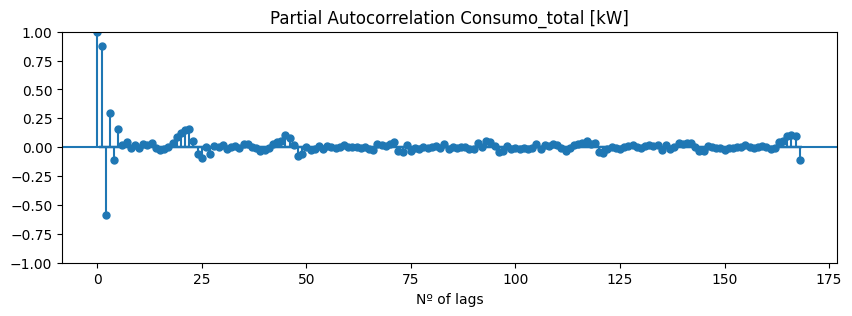

In [127]:
from statsmodels.graphics.tsaplots import plot_pacf
#Gráfico de autocorrelación parcial
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")
plot_pacf(demand_df_1h["Consumo_kW"], ax=ax, lags=24*7)
plt.title("Partial Autocorrelation Consumo_total [kW]")
plt.show()

## Correlation Matrix

In [128]:
df5.columns

Index(['index', 'Consumo_kW', 'Consumo_smooth_mean_kW', 'temperature_2m_C',
       'relative_humidity_2m_%', 'dew_point_2m_C', 'apparent_temperature_C',
       'pressure_msl_hPa', 'surface_pressure_hPa', 'cloud_cover_%',
       'cloud_cover_high_%', 'et0_fao_evapotranspiration_mm',
       'vapour_pressure_deficit_kPa', 'wind_speed_10m_km/h',
       'wind_direction_10m_º', 'wind_gusts_10m', 'is_day',
       'sunshine_duration_sec', 'shortwave_radiation_W/m2',
       'direct_radiation_W/m2', 'diffuse_radiation_W/m2',
       'direct_normal_irradiance_W/m2', 'global_tilted_irradiance_W/m2',
       'terrestrial_radiation_W/m2', 'Temp_interna_Modulo_C', 'PV_kWh', 'Year',
       'Month', 'Hour', 'DayOfWeek', 'DayOfYear', 'isWeekend', 'Hour_sin',
       'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos',
       'DayOfYear_sin', 'DayOfYear_cos', 'isHoliday', 'Season'],
      dtype='object')

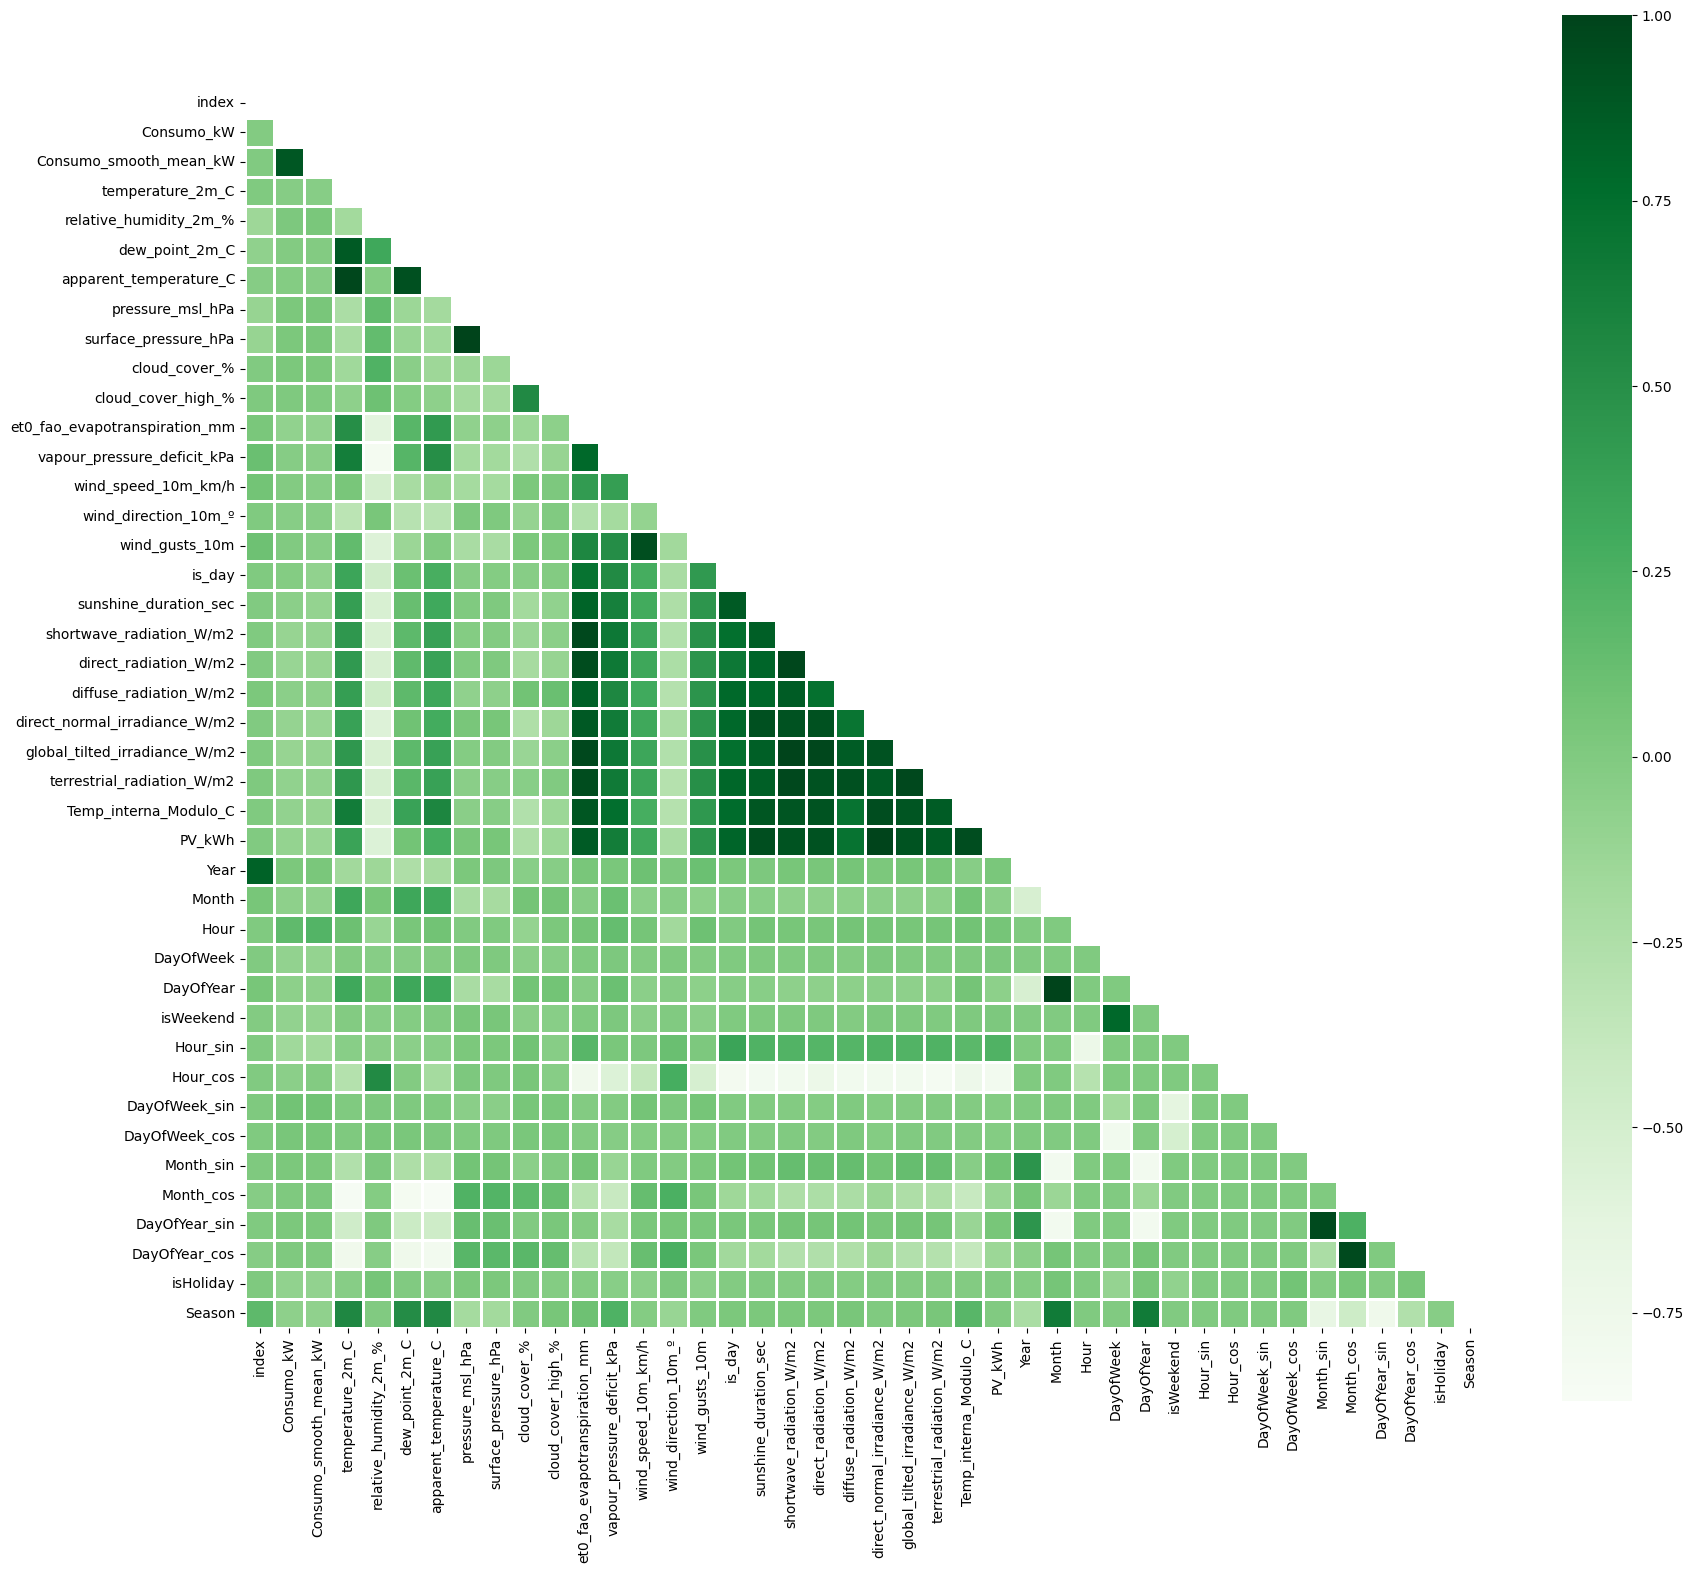

In [129]:
# Calcula la matriz de correlación completa
correlation_matrix = df5.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Imprime la matriz de correlación del cuadrante inferior
#plotting the heatmap for correlation
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, mask=mask, square=True, cmap='Greens', linewidths=2, linecolor='white');

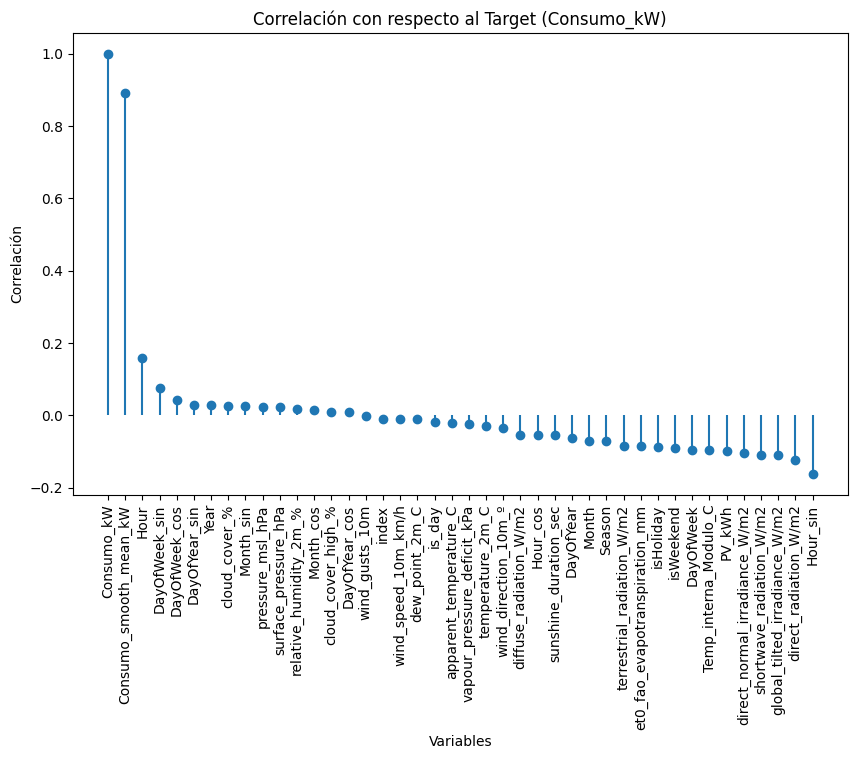

In [136]:
# VERSION LOLIPOP
# Ordenar el DataFrame de manera decreciente según la columna 'Consumo_kW'
sorted_correlation = correlation_matrix.sort_values(by='Consumo_kW', ascending=False)

# Crear un gráfico lollipop de la correlación respecto a la variable específica
plt.figure(figsize=(10, 6))
plt.stem(sorted_correlation.index, sorted_correlation['Consumo_kW'], basefmt=" ")
plt.title('Correlación con respecto al Target (Consumo_kW)')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=90)
plt.show()

# VERSION BARRAS
# # Ordenar el DataFrame de manera decreciente según la columna 'Consumo_kW'
# sorted_correlation = correlation_matrix.sort_values(by='Consumo_kW', ascending=False)

# # Crear un gráfico de barras de la correlación respecto a la variable específica
# plt.figure(figsize=(10, 6))
# sns.barplot(x=sorted_correlation.index, y=sorted_correlation['Consumo_kW'])
# plt.title('Correlación con respecto al Target (Consumo_kW)')
# plt.xlabel('Variables')
# plt.ylabel('Correlación')
# plt.xticks(rotation=90)
# plt.show()

## Time series decpomposition

In [137]:
def decompose_time_series(df, column, freq):
    result = seasonal_decompose(df[column], model='additive', period=freq)
    df[f"{column}_trend"] = result.trend
    df[f"{column}_seasonal"] = result.seasonal
    df[f"{column}_residual"] = result.resid
    return df

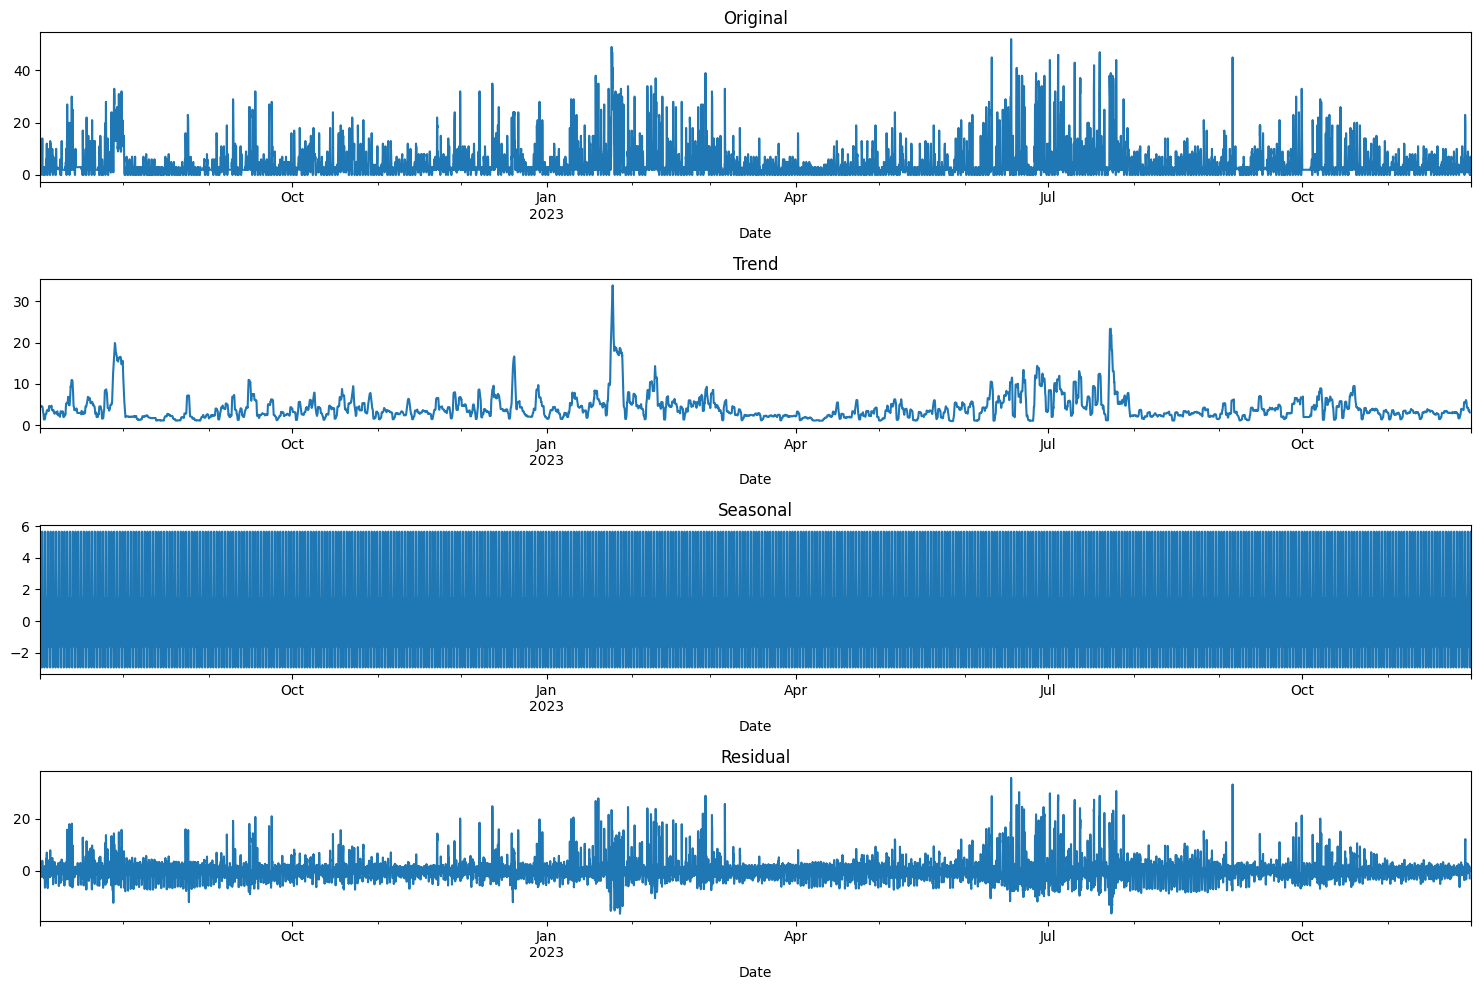

In [138]:
decomposed_df = decompose_time_series(df5, "Consumo_kW", 96)

decomposed_df.reset_index(inplace=True, drop=False)

decomposed_df.set_index('Date', inplace=True)

# Plot the decomposed time series
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomposed_df["Consumo_kW"].plot(ax=axes[0], title="Original")
decomposed_df["Consumo_kW_trend"].plot(ax=axes[1], title="Trend")
decomposed_df["Consumo_kW_seasonal"].plot(ax=axes[2], title="Seasonal")
decomposed_df["Consumo_kW_residual"].plot(ax=axes[3], title="Residual")
plt.tight_layout()

# SAVE csv

In [139]:
# Guardar el DataFrame como CSV
nombre_archivo = "LaMonserratina_CLEAN.csv"
ruta_completa = os.path.join(ruta_data, nombre_archivo)
df5.to_csv(ruta_completa, index=False)